# Training and Tuning AGNBoost Models from Scratch

This notebook demonstrates how to train and tune your own AGNBoost models. We'll walk through:

1. Displaying what trained models are available
2. Training new models
3. Tuning the models 

Let's start by importing the necessary libraries and loading our data.

In [2]:
# Set agnboost folder as root
import os

# Navigate to the repository root (parent directory of notebooks/)
os.chdir('..')

# Import necessary libraries
import numpy as np
import pandas as pd
from agnboost import dataset, model
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(123)

print("AGNBoost Basic Usage Tutorial")
print("=" * 40)

2025-05-31 21:17:14.384 | INFO     | agnboost.config:<module>:11 - PROJ_ROOT path is: /home/kurt/Documents/agnboost


AGNBoost Basic Usage Tutorial


## Loading the Data + Train/Val/Test Split

We'll use the Catalog class to load our astronomical dataset. The `cigale_mock_small.csv` file contains is a small set of mock NIRCam+MIRI CIGALE galaxies for demonstration purposes.

Let's load the data and then split the data so we have 60% for training, 20% for validation, and 20% for testing.

In [23]:
# Load the astronomical data using the Catalog class with all NIRCam+MIRI bands
catalog = dataset.Catalog(path="data/cigale_mock_small.csv",summarize = False)

# Create train/validation/test splitsget_train_val_test_sizes
catalog.split_data(test_size=0.2, val_size=0.2, random_state=42)

# Get split information
split_info = catalog.get_train_val_test_sizes()
print("Data split summary:")
print(f"  Total samples: {split_info['total']}")
print(f"  Training: {split_info['train']['size']} ({split_info['train']['percentage']:.1f}%)")
print(f"  Validation: {split_info['validation']['size']} ({split_info['validation']['percentage']:.1f}%)")
print(f"  Test: {split_info['test']['size']} ({split_info['test']['percentage']:.1f}%)")

Current working directory: /home/kurt/Documents/agnboost
Looking for bands file at: /home/kurt/Documents/agnboost/agnboost/allowed_bands.json
[INFO] Loaded bands file metadata: This file contains the allowed photometric bands for JWST
[INFO] Loaded 11 allowed bands from agnboost/allowed_bands.json
[INFO] Attempting to load file with delimiter: ','
[INFO] Successfully loaded data with 1000 rows.
[INFO] Found 11 valid band columns:
[INFO]   - jwst.nircam.F115W (F115W): 1.154 μm
[INFO]   - jwst.nircam.F150W (F150W): 1.501 μm
[INFO]   - jwst.nircam.F200W (F200W): 1.988 μm
[INFO]   - jwst.nircam.F277W (F277W): 2.776 μm
[INFO]   - jwst.nircam.F356W (F356W): 3.565 μm
[INFO]   - jwst.nircam.F410M (F410M): 4.083 μm
[INFO]   - jwst.nircam.F444W (F444W): 4.402 μm
[INFO]   - jwst.miri.F770W (F770W): 7.7 μm
[INFO]   - jwst.miri.F1000W (F1000W): 10.0 μm
[INFO]   - jwst.miri.F1500W (F1500W): 15.0 μm
[INFO]   - jwst.miri.F2100W (F2100W): 21.0 μm
Data split summary:
  Total samples: 1000
  Training: 60

## Creating Features

We then need to create our features. We will use the default features (phots + colors + colors^2)/

In [4]:
# Create features for modeling
catalog.create_feature_dataframe()

# Get information about created features
features = catalog.get_features()
print(f"Feature engineering complete:")
print(f"  Feature dataframe shape: {features.shape}")


[INFO] Created feature dataframe with 121 columns and 1000 rows.
[INFO] Created features are: ['jwst.nircam.F115W', 'jwst.nircam.F150W', 'jwst.nircam.F200W', 'jwst.nircam.F277W', 'jwst.nircam.F356W', 'jwst.nircam.F410M', 'jwst.nircam.F444W', 'jwst.miri.F770W', 'jwst.miri.F1000W', 'jwst.miri.F1500W', 'jwst.miri.F2100W', 'F2100W/F1500W', 'F2100W/F1000W', 'F2100W/F770W', 'F2100W/F444W', 'F2100W/F410M', 'F2100W/F356W', 'F2100W/F277W', 'F2100W/F200W', 'F2100W/F150W', 'F2100W/F115W', 'F1500W/F1000W', 'F1500W/F770W', 'F1500W/F444W', 'F1500W/F410M', 'F1500W/F356W', 'F1500W/F277W', 'F1500W/F200W', 'F1500W/F150W', 'F1500W/F115W', 'F1000W/F770W', 'F1000W/F444W', 'F1000W/F410M', 'F1000W/F356W', 'F1000W/F277W', 'F1000W/F200W', 'F1000W/F150W', 'F1000W/F115W', 'F770W/F444W', 'F770W/F410M', 'F770W/F356W', 'F770W/F277W', 'F770W/F200W', 'F770W/F150W', 'F770W/F115W', 'F444W/F410M', 'F444W/F356W', 'F444W/F277W', 'F444W/F200W', 'F444W/F150W', 'F444W/F115W', 'F410M/F356W', 'F410M/F277W', 'F410M/F200W', 'F41

## Creating a new model

First, let's take a look at the columns of our saved data to see what our regression options are.

In [5]:
# Print columns in data
print( catalog.get_data().columns )

Index(['IRAC1', 'IRAC2', 'IRAC3', 'IRAC4', 'hst.acs.wfc.F606W',
       'hst.acs.wfc.F814W', 'hst.wfc3.ir.F125W', 'hst.wfc3.ir.F140W',
       'hst.wfc3.ir.F160W', 'jwst.miri.F1000W', 'jwst.miri.F1280W',
       'jwst.miri.F1500W', 'jwst.miri.F1800W', 'jwst.miri.F2100W',
       'jwst.miri.F770W', 'jwst.nircam.F115W', 'jwst.nircam.F150W',
       'jwst.nircam.F200W', 'jwst.nircam.F277W', 'jwst.nircam.F356W',
       'jwst.nircam.F410M', 'jwst.nircam.F444W', 'sfh.sfr100Myrs',
       'stellar.m_star', 'agn.fracAGN', 'universe.redshift'],
      dtype='object')


Let's say we wanted to create our own model to estimate the `agn.fracAGN` (i.e. frac$_\text{AGN}$), parameter (recall that this is the fraction of 3-30 micron light attributable to an AGN power law). We first need to instantiate an AGNBoost model with `agn.fracAGN`  as the target variable. We already know that frac$_\text{AGN}$ is bounded [0,1), but let's first quickly visualize the distribution of `agn.fracAGN` to decide what type of probability distribution to model.

min fracAGN: 0.0
max fracAGN: 0.99


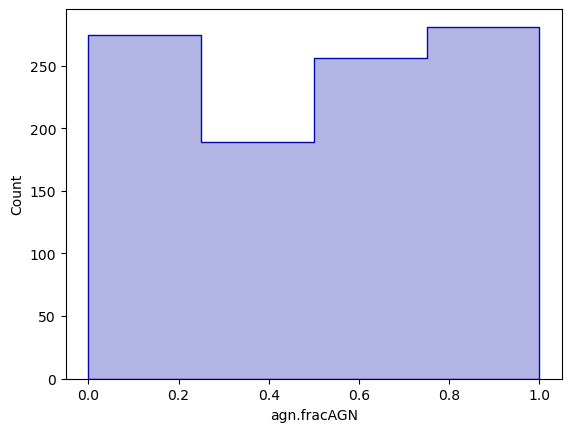

In [10]:
fig, ax = plt.subplots()

bins_width = 0.25
bins = np.arange(0, 1 + bins_width, bins_width)
fagn_data = catalog.get_data()['agn.fracAGN']
sns.histplot( x = catalog.get_data()['agn.fracAGN'], ax = ax, bins = bins, color = 'xkcd:cobalt blue',  element = 'step', fill = True, alpha = 0.3)

print(f"min fracAGN: {np.min(fagn_data )}")
print(f"max fracAGN: {np.max(fagn_data )}")

As expected, the `agn.fracAGN` variable is bounded [0, 1), so we will model it with a zero-inflated beta distribution (ZABeta). Let us instantiate a AGNBoost model with `agn.fracAGN` as the target variable, and using ZABeta as the modeled probabiltiy distribution:

In [12]:
# Initialize an AGNBoost model. The target variable is the name of the target variable column, and its value in the passed dictionary is the distribution used to model it.
agnboost_m = model.AGNBoost( feature_names = catalog.get_feature_names(),
                          target_variables = {'agn.fracAGN' : 'ZABeta'},
                         )

## Model Tuning

We have created the AGNBoost model, but before we can train a production model to predict `agn.fracAGN`, we need to tune the hyperparameters of AGNBoost. 

The XGBoostLSS models themselves generally have 3 tunable hyperparamters:
<ol>
    <li>Stabilization: "None", "MAD" (i.e., L1), "L2"</li>
    <li>response_sn: "exp", "softplus"</li>
    <li>loss_fn: "nll", "crps"</li>
</ol>

For the details of these hyperparameters, and the options for each individual XGBoostLSS distribution, please refer to the [XGBoostLSS documentation](https://statmixedml.github.io/XGBoostLSS/), and the [XGBoostLSS code on GitHub](https://github.com/StatMixedML/XGBoostLSS/tree/master/xgboostlss/distributions). For a full list of XGBoost booster hyperparameters, refer to the [XGBoost documentation](https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster).

To perform hyperparameter tuning, we need to create a python dictionary that defines what hyperparameters to vary, and the possible values or value ranges of the parameter. [This needs to be formatted a specific way](https://statmixedml.github.io/XGBoostLSS/examples/Gaussian_Regression/):

```
- Float/Int sample_type
    - {"param_name": ["sample_type", low, high, log]}
        - sample_type: str, Type of sampling, e.g., "float" or "int"
        - low: int, Lower endpoint of the range of suggested values
        - high: int, Upper endpoint of the range of suggested values
        - log: bool, Flag to sample the value from the log domain or not
    - Example: {"eta": "float", low=1e-5, high=1, log=True]}

- Categorical (or None) sample_type
    - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
        - sample_type: str, Type of sampling, either "categorical"
        - choice1, choice2, choice3, ...: str, Possible choices for the parameter
    - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

```

Note that the "categorical" and "None" data types are equivalent and used interchangeably. Let's pick a few XGBoostLSS and XGBoost hyperparameters to tune:



In [24]:
param_dict = {
    "stabilization":          ["categorical", ["None", "MAD", "L2"]],
    "response_fn":          ["categorical", ["softplus", "exp"]],

    "eta":              ["none", [.5]],
    "tree_method":    ["categorical", ["hist","approx"] ],
    "max_depth":        ["int",   {"low": 3,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}], 
    "min_child_weight": ["int", {"low": 1,   "high": 250,  "log": False}],
    "lambda":            ["float", {"low": 1,   "high": 150,    "log": True}], 

    "device" : ["categorical", ["cpu"] ]
}


#### Sidenote: GPU usage
If you have a NVIDIA CUDA compatible GPU, you can certainly make use of it to train AGNBoost models. To do this, ensure that your XGBoost instllation is gpu-compatible, see the example [here](https://xgboosting.com/check-if-xgboost-supports-gpu/), and to install gpu-compatible xgboost, see the docs [here](https://xgboost.readthedocs.io/en/stable/install.html). To use the gpu for training, you need to set `"device" : ["categorical", ["gpu"]` ]. Just note that it is really only worth using the GPU if you are using about a million or so points of data for training. Any less than that and using the CPU will generally be faster.

Now that we have our parameter dictionary, we can begin the tuning process. Fortuantely, this is very simple:

In [25]:
best_params_1stpass = agnboost_m.tune_model( model_name = 'agn.fracAGN',
                                             param_grid = param_dict,
                                             dtune = catalog,
                                            max_minutes = 10, #We will tune for 10 minutes. You will probably want to tune for much longer!
                                             split_type = 'trainval'  #Options: train, val, test, trainval. trainval uses the combined train+val test split
                                           )

2025-05-31 21:59:39,310 - AGNBoost.AGNBoost - WARNING - Catalog object passsed. Taking the features and labels of the trainval set stored in the passed Catalog.
``multivariate`` option is an experimental feature. The interface can change in the future.
[I 2025-05-31 21:59:39,337] A new study created in memory with name: no-name-15235329-2d3f-4858-ab06-f5bb2604f0d8


[INFO] Created feature dataframe with 121 columns and 1000 rows.
[INFO] Created features are: ['jwst.nircam.F115W', 'jwst.nircam.F150W', 'jwst.nircam.F200W', 'jwst.nircam.F277W', 'jwst.nircam.F356W', 'jwst.nircam.F410M', 'jwst.nircam.F444W', 'jwst.miri.F770W', 'jwst.miri.F1000W', 'jwst.miri.F1500W', 'jwst.miri.F2100W', 'F2100W/F1500W', 'F2100W/F1000W', 'F2100W/F770W', 'F2100W/F444W', 'F2100W/F410M', 'F2100W/F356W', 'F2100W/F277W', 'F2100W/F200W', 'F2100W/F150W', 'F2100W/F115W', 'F1500W/F1000W', 'F1500W/F770W', 'F1500W/F444W', 'F1500W/F410M', 'F1500W/F356W', 'F1500W/F277W', 'F1500W/F200W', 'F1500W/F150W', 'F1500W/F115W', 'F1000W/F770W', 'F1000W/F444W', 'F1000W/F410M', 'F1000W/F356W', 'F1000W/F277W', 'F1000W/F200W', 'F1000W/F150W', 'F1000W/F115W', 'F770W/F444W', 'F770W/F410M', 'F770W/F356W', 'F770W/F277W', 'F770W/F200W', 'F770W/F150W', 'F770W/F115W', 'F444W/F410M', 'F444W/F356W', 'F444W/F277W', 'F444W/F200W', 'F444W/F150W', 'F444W/F115W', 'F410M/F356W', 'F410M/F277W', 'F410M/F200W', 'F41

   0%|          | 00:00/10:00

4.3 seconds
[I 2025-05-31 21:59:43,603] Trial 0 finished with value: -538.3346859999999 and parameters: {'stabilization': 'MAD', 'response_fn': 'softplus', 'eta': 0.5, 'tree_method': 'hist', 'max_depth': 10, 'gamma': 2.5396329035358637e-05, 'min_child_weight': 17, 'lambda': 25.752571083027494, 'device': 'cpu'}. Best is trial 0 with value: -538.3346859999999.
1.4 seconds
[I 2025-05-31 21:59:45,029] Trial 1 finished with value: -233.0358885 and parameters: {'stabilization': 'L2', 'response_fn': 'exp', 'eta': 0.5, 'tree_method': 'approx', 'max_depth': 6, 'gamma': 0.009805474860380612, 'min_child_weight': 222, 'lambda': 36.97821636577757, 'device': 'cpu'}. Best is trial 0 with value: -538.3346859999999.
2.0 seconds
[I 2025-05-31 21:59:47,073] Trial 2 finished with value: -568.1241150000001 and parameters: {'stabilization': 'MAD', 'response_fn': 'softplus', 'eta': 0.5, 'tree_method': 'approx', 'max_depth': 9, 'gamma': 1.4233405719313036e-08, 'min_child_weight': 156, 'lambda': 5.785645476080

invalid value encountered in subtract


1.9 seconds
[I 2025-05-31 21:59:52,643] Trial 5 finished with value: 100000000.0 and parameters: {'stabilization': 'MAD', 'response_fn': 'exp', 'eta': 0.5, 'tree_method': 'approx', 'max_depth': 4, 'gamma': 4.7025417911805535e-05, 'min_child_weight': 80, 'lambda': 3.4752834971002446, 'device': 'cpu'}. Best is trial 2 with value: -568.1241150000001.
1.9 seconds
[I 2025-05-31 21:59:54,506] Trial 6 finished with value: -440.689758 and parameters: {'stabilization': 'L2', 'response_fn': 'exp', 'eta': 0.5, 'tree_method': 'approx', 'max_depth': 6, 'gamma': 1.7553267516359528e-05, 'min_child_weight': 80, 'lambda': 50.83870744181027, 'device': 'cpu'}. Best is trial 2 with value: -568.1241150000001.
2.1 seconds
[I 2025-05-31 21:59:56,626] Trial 7 finished with value: -571.186035 and parameters: {'stabilization': 'MAD', 'response_fn': 'softplus', 'eta': 0.5, 'tree_method': 'hist', 'max_depth': 6, 'gamma': 1.5543187142694343e-07, 'min_child_weight': 134, 'lambda': 7.636122743857147, 'device': 'cpu'

invalid value encountered in add


[I 2025-05-31 22:00:49,287] Trial 41 pruned. Trial was pruned at iteration 125.
[I 2025-05-31 22:00:50,026] Trial 42 pruned. Trial was pruned at iteration 20.
[I 2025-05-31 22:00:50,761] Trial 43 pruned. Trial was pruned at iteration 20.
[I 2025-05-31 22:00:52,781] Trial 44 pruned. Trial was pruned at iteration 125.
[I 2025-05-31 22:00:53,367] Trial 45 pruned. Trial was pruned at iteration 20.
1.8 seconds
[I 2025-05-31 22:00:55,195] Trial 46 finished with value: -565.3455505 and parameters: {'stabilization': 'MAD', 'response_fn': 'softplus', 'eta': 0.5, 'tree_method': 'hist', 'max_depth': 4, 'gamma': 1.8679492218445252e-07, 'min_child_weight': 126, 'lambda': 3.4176836684664607, 'device': 'cpu'}. Best is trial 40 with value: -571.6891175000001.
2.1 seconds
[I 2025-05-31 22:00:57,349] Trial 47 finished with value: -550.0536195 and parameters: {'stabilization': 'MAD', 'response_fn': 'softplus', 'eta': 0.5, 'tree_method': 'hist', 'max_depth': 5, 'gamma': 5.007938682813857e-08, 'min_child_w

invalid value encountered in subtract
invalid value encountered in add


2.1 seconds
[I 2025-05-31 22:01:17,491] Trial 63 finished with value: 100000000.0 and parameters: {'stabilization': 'MAD', 'response_fn': 'exp', 'eta': 0.5, 'tree_method': 'approx', 'max_depth': 3, 'gamma': 4.82218843841422, 'min_child_weight': 97, 'lambda': 46.86953830724628, 'device': 'cpu'}. Best is trial 40 with value: -571.6891175000001.
[I 2025-05-31 22:01:18,141] Trial 64 pruned. Trial was pruned at iteration 20.


invalid value encountered in subtract


2.1 seconds
[I 2025-05-31 22:01:20,215] Trial 65 finished with value: 100000000.0 and parameters: {'stabilization': 'MAD', 'response_fn': 'exp', 'eta': 0.5, 'tree_method': 'approx', 'max_depth': 3, 'gamma': 0.000131061786050065, 'min_child_weight': 68, 'lambda': 21.07070990752435, 'device': 'cpu'}. Best is trial 40 with value: -571.6891175000001.
1.9 seconds
[I 2025-05-31 22:01:22,081] Trial 66 finished with value: -554.254608 and parameters: {'stabilization': 'MAD', 'response_fn': 'softplus', 'eta': 0.5, 'tree_method': 'approx', 'max_depth': 5, 'gamma': 7.936866283744524e-07, 'min_child_weight': 70, 'lambda': 24.188763934320402, 'device': 'cpu'}. Best is trial 40 with value: -571.6891175000001.


invalid value encountered in subtract


2.2 seconds
[I 2025-05-31 22:01:24,331] Trial 67 finished with value: 100000000.0 and parameters: {'stabilization': 'MAD', 'response_fn': 'exp', 'eta': 0.5, 'tree_method': 'hist', 'max_depth': 3, 'gamma': 0.02637272250292243, 'min_child_weight': 75, 'lambda': 70.54541585403223, 'device': 'cpu'}. Best is trial 40 with value: -571.6891175000001.
[I 2025-05-31 22:01:24,915] Trial 68 pruned. Trial was pruned at iteration 20.
[I 2025-05-31 22:01:25,619] Trial 69 pruned. Trial was pruned at iteration 20.
1.8 seconds
[I 2025-05-31 22:01:27,436] Trial 70 finished with value: -572.7865294999999 and parameters: {'stabilization': 'MAD', 'response_fn': 'softplus', 'eta': 0.5, 'tree_method': 'approx', 'max_depth': 3, 'gamma': 0.007191774416874417, 'min_child_weight': 96, 'lambda': 122.73669366406183, 'device': 'cpu'}. Best is trial 70 with value: -572.7865294999999.
1.8 seconds
[I 2025-05-31 22:01:29,235] Trial 71 finished with value: -534.8459625 and parameters: {'stabilization': 'MAD', 'response_

invalid value encountered in subtract


2.5 seconds
[I 2025-05-31 22:03:02,860] Trial 133 finished with value: 100000000.0 and parameters: {'stabilization': 'MAD', 'response_fn': 'exp', 'eta': 0.5, 'tree_method': 'hist', 'max_depth': 7, 'gamma': 8.52159439565328e-08, 'min_child_weight': 53, 'lambda': 97.20698026222445, 'device': 'cpu'}. Best is trial 104 with value: -585.4270630000001.
[I 2025-05-31 22:03:03,501] Trial 134 pruned. Trial was pruned at iteration 20.
1.9 seconds
[I 2025-05-31 22:03:05,455] Trial 135 finished with value: -564.3602295 and parameters: {'stabilization': 'MAD', 'response_fn': 'softplus', 'eta': 0.5, 'tree_method': 'approx', 'max_depth': 8, 'gamma': 0.983718521423068, 'min_child_weight': 115, 'lambda': 126.82858131454422, 'device': 'cpu'}. Best is trial 104 with value: -585.4270630000001.
[I 2025-05-31 22:03:06,076] Trial 136 pruned. Trial was pruned at iteration 20.
[I 2025-05-31 22:03:06,775] Trial 137 pruned. Trial was pruned at iteration 20.
1.5 seconds
[I 2025-05-31 22:03:08,281] Trial 138 finis

invalid value encountered in subtract


2.5 seconds
[I 2025-05-31 22:05:07,073] Trial 204 finished with value: 100000000.0 and parameters: {'stabilization': 'MAD', 'response_fn': 'exp', 'eta': 0.5, 'tree_method': 'hist', 'max_depth': 10, 'gamma': 0.3144912311448094, 'min_child_weight': 64, 'lambda': 71.25598865752376, 'device': 'cpu'}. Best is trial 187 with value: -599.183777.
2.7 seconds
[I 2025-05-31 22:05:09,837] Trial 205 finished with value: -591.6864925 and parameters: {'stabilization': 'None', 'response_fn': 'exp', 'eta': 0.5, 'tree_method': 'hist', 'max_depth': 10, 'gamma': 1.0389562372846309e-07, 'min_child_weight': 16, 'lambda': 92.9559870292283, 'device': 'cpu'}. Best is trial 187 with value: -599.183777.
[I 2025-05-31 22:05:10,498] Trial 206 pruned. Trial was pruned at iteration 20.
2.7 seconds
[I 2025-05-31 22:05:13,247] Trial 207 finished with value: -584.461151 and parameters: {'stabilization': 'None', 'response_fn': 'exp', 'eta': 0.5, 'tree_method': 'hist', 'max_depth': 10, 'gamma': 2.085923081816322e-05, 'm

Now, with this optimized set of parameters, we can start training models! First, let's reduce the training rate (eta) to a lower value so that we can find the optimal number of boosting rounds. We will train a model with the training set and evaluate it with the validation set at each iteration. The iteration set after which the loss on the valdation set begins to increase will be the optimal number of rounds (this is known as early stopping, [see the docs here](https://xgboost.readthedocs.io/en/stable/python/python_intro.html#early-stopping) for more information).

2025-06-01 00:36:07,607 - AGNBoost.AGNBoost - WARNING - Catalog object passsed. Taking the features and labels of the train set stored in the passed Catalog.


16.9 seconds to train model
Optimal number of boosting rounds: 2050


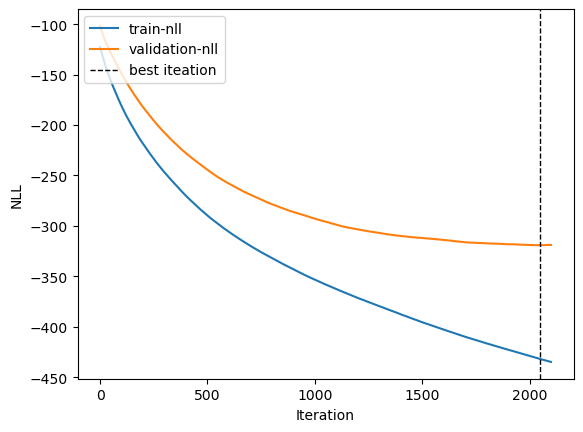

In [100]:
# Set learning rate in best params to a smaller value
best_params_1stpass['eta'] = 0.01

# Alternatively, you can overwrite the eta saved in the tuning params in the AGNBoost instance
# Then, you can run agnboost_m.train_model without passing in a params dict, as it will by default use the tuned params.
#  agnboost_m.model_info['agn.fracAGN']['tuned_params']['eta'] = 0.01

model, eval_results = agnboost_m.train_model( model_name = 'agn.fracAGN',
                                           dtrain = catalog, 
                                             params = best_params_1stpass,
                                           split_type='train', # Use the training split for training
                                            dval = True,  # Evaluate with the validation set at each training step.
                                            early_stopping_rounds = 50, # When the loss on the vlidation set increases after 50 consecutive iterations, stop training.
                                            num_boost_round = 10**4 # The maximm number of boosting rounds
                                          )

# Print the best iteration
opt_rounds = agnboost_m.model_info['agn.fracAGN']['best_iteration']
print(f"Optimal number of boosting rounds: {opt_rounds}")

# Plot the trainign and validation loss curves
ax = agnboost_m.plot_eval( evals = eval_results, catalog = catalog, best_iter = opt_rounds )
